In [1]:
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import matplotlib as mpl
from sklearn.decomposition import PCA
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
)
%load_ext skip_kernel_extension

In [2]:
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [3]:
SKIP_RETRAIN_NN =True
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = False
SKIP_RETRAIN_ED_LSTM = True

## Loading Data

In [4]:
combined_df = pd.read_csv("preprocessed_data.csv")
combined_df = set_timestamp_index(combined_df,"Unnamed: 0")

In [5]:
combined_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,49.0,196.0,6378.0,25385.0,65.41,28251.0,2866.0,1,1,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,50.0,195.0,5890.0,24382.0,64.92,27818.0,3436.0,1,1,0
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,50.0,196.0,5461.0,22734.0,64.48,26796.0,4062.0,1,1,0
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,50.0,191.0,5238.0,21286.0,59.32,25223.0,3937.0,1,1,0
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,42.0,189.0,4935.0,20264.0,56.04,24620.0,4356.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,85.0,277.0,3113.0,30653.0,77.02,26415.0,-4238.0,12,31,0
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,33.0,280.0,3288.0,29735.0,76.16,25213.0,-4522.0,12,31,0
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,31.0,286.0,3503.0,28071.0,74.30,23987.0,-4084.0,12,31,0
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,31.0,287.0,3586.0,25801.0,69.89,22748.0,-3053.0,12,31,0


# LSTM

## Single Step LSTM

Scale the input data

In [ ]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [ ]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-06'
feature = 'total load actual'
namespace = 'LSTM'
modeltype = 'LSTM'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [ ]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,24,1,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,24,1,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,24,1,32)

In [ ]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(17510, 24, 26) (17510, 1)
(1382, 24, 26) (1382, 1)
(70, 24, 26) (70, 1)


Define LSTM Model

In [ ]:
def build_model_LSTM(data_x_train,data_y_train):
    n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
    model = models.Sequential([
    layers.LSTM(32, return_sequences=True,input_shape=(None, n_features), stateful=False), 
    layers.BatchNormalization(),
    layers.LSTM(32, return_sequences=True, stateful=False),
    layers.BatchNormalization(),
    layers.LSTM(32, stateful=False),
    layers.BatchNormalization(),
    layers.Dense(n_outputs)                     
    ])
    model.compile(optimizer='Adam',loss='mse',metrics='mae') 
    return model

Definening callback functions

In [ ]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint(f"./{modeltype}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

Hypterparameters

In [ ]:
num_epochs = 150
batch_size = 32

Training the model

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

model_LSTM = build_model_LSTM(data_x_train,data_y_train)
history_LSTM = model_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])#, verbose=0)

Epoch 1/150
548/548 [==============================] - 10s 11ms/step - loss: 828805376.0000 - mae: 28432.4922 - val_loss: 905604736.0000 - val_mae: 29682.7559
Epoch 2/150
548/548 [==============================] - 6s 10ms/step - loss: 825397696.0000 - mae: 28384.7207 - val_loss: 898402880.0000 - val_mae: 29579.7012
Epoch 3/150
548/548 [==============================] - 6s 10ms/step - loss: 819384128.0000 - mae: 28296.0117 - val_loss: 887870528.0000 - val_mae: 29426.8164
Epoch 4/150
548/548 [==============================] - 6s 10ms/step - loss: 811167232.0000 - mae: 28172.1113 - val_loss: 874174208.0000 - val_mae: 29222.2871
Epoch 5/150
548/548 [==============================] - 6s 10ms/step - loss: 801115968.0000 - mae: 28017.9336 - val_loss: 863985152.0000 - val_mae: 29078.5840
Epoch 6/150
548/548 [==============================] - 6s 10ms/step - loss: 789463936.0000 - mae: 27836.5156 - val_loss: 847329088.0000 - val_mae: 28825.6738
Epoch 7/150
548/548 [==============================

Evaluate the training process

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

histLSTM = pd.DataFrame(history_LSTM.history)
histLSTM['epoch'] = history_LSTM.epoch

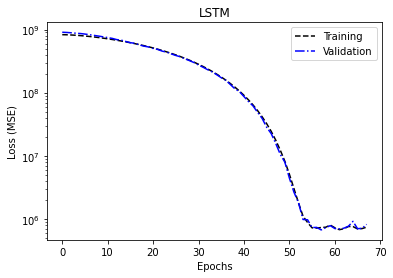

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

fig = plot_learning_curves(histLSTM,modeltype,f"./{modeltype}/learningcurve_{namespace}.png")

Load best model

In [ ]:
model_best_LSTM = keras.models.load_model(f"./{modeltype}/my_best_model_{namespace}.h5")
model_best_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 32)          7552      
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 32)          128       
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
batch_normalization_8 (Batch (None, None, 32)          128       
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [ ]:
Y_test_predictions = pd.Series(model_best_LSTM.predict(data_x_test).flatten(),index=y_test_filtered.index)
y_test_filtered = data_y_test0.loc[idx_test]
y_test_filtered =y_test_filtered.squeeze(axis=1)

In [ ]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

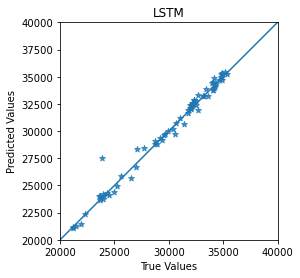

In [ ]:
fig = plot_accuracy(eval_df,modeltype,f"./{modeltype}/accuracy_{namespace}.png")

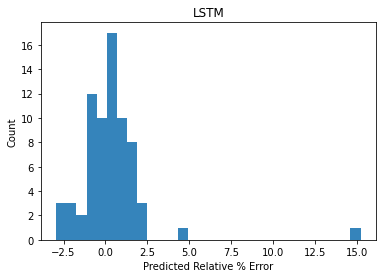

In [ ]:
fig = plot_error_variations(eval_df,modeltype,f"./{modeltype}/error_variations_{namespace}.png")

In [ ]:
abs_error_LSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_LSTM)

1.1866846879292747

In [ ]:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.98


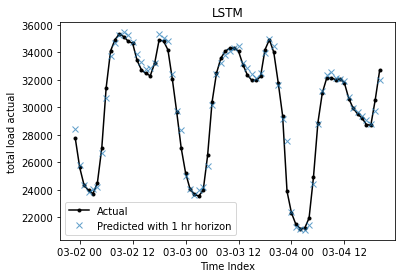

In [ ]:
fig = plot_predictions(eval_df,1,modeltype,feature,f"./{modeltype}/learningcurve_{namespace}.png")

## Mulitstep LSTM

Scale the input data

In [ ]:
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [ ]:
scaled_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
2015-01-01 00:00:00+01:00,-2.807250,-1.254819,0.605043,-0.724273,-0.820537,0.743671,-0.335844,-0.353717,0.287706,-2.596050,...,-0.823732,-1.462008,0.284116,-0.724094,0.529854,-0.092704,1.133008,-1.601685,-1.673784,-0.633062
2015-01-01 01:00:00+01:00,-2.807250,-1.254819,0.605043,-0.724273,-0.820537,0.767106,-0.338664,-0.193824,0.254067,-2.672213,...,-0.823137,-1.481921,0.132259,-0.943292,0.495356,-0.196137,1.353784,-1.601685,-1.673784,-0.633062
2015-01-01 02:00:00+01:00,-2.916311,-1.171050,0.655861,-1.161697,-1.144428,0.755388,-0.352763,-0.347812,0.165380,-2.691253,...,-0.823137,-1.462008,-0.001239,-1.303451,0.464379,-0.440270,1.596250,-1.601685,-1.673784,-0.633062
2015-01-01 03:00:00+01:00,-2.916311,-1.171050,0.655861,-1.161697,-1.144428,0.638217,-0.547342,-0.594464,-0.063983,-2.634131,...,-0.823137,-1.561575,-0.070633,-1.619900,0.101098,-0.816024,1.547834,-1.601685,-1.673784,-0.633062
2015-01-01 04:00:00+01:00,-2.916311,-1.171050,0.655861,-1.161697,-1.144428,0.521046,-0.736280,-0.678044,-0.212304,-2.710294,...,-0.827899,-1.601401,-0.164921,-1.843251,-0.129825,-0.960067,1.710124,-1.601685,-1.673784,-0.633062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,-0.711034,1.006965,-0.157230,-0.286850,-0.172756,-1.013900,-1.263615,0.913613,-0.830053,-2.291399,...,-0.802303,0.150969,-0.731897,0.427190,1.347236,-0.531282,-1.618560,1.587925,1.735195,-0.633062
2018-12-31 20:00:00+01:00,-1.056602,1.090734,0.300134,-0.724273,0.674344,-1.025617,-1.263615,0.735096,-0.861654,-2.367562,...,-0.833256,0.210709,-0.677440,0.226567,1.286689,-0.818413,-1.728560,1.587925,1.735195,-0.633062
2018-12-31 21:00:00+01:00,-1.261179,1.090734,0.808315,0.150573,1.156028,-1.072486,-1.263615,0.636980,-0.935050,-2.481806,...,-0.834447,0.330188,-0.610535,-0.137088,1.155739,-1.111276,-1.558911,1.587925,1.735195,-0.633062
2018-12-31 22:00:00+01:00,-1.471284,1.090734,0.808315,-0.286850,1.239077,-1.060769,-1.263615,0.426667,-1.000800,-2.577009,...,-0.834447,0.350102,-0.584707,-0.633180,0.845260,-1.407245,-1.159578,1.587925,1.735195,-0.633062


In [ ]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-14'
feature = 'total load actual'
model_type = 'LSTM'
namespace = 'MS_LSTM_LOAD'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [ ]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,72,24,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,72,24,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,72,24,32)


In [ ]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(17416, 72, 26) (17416, 24)
(1288, 72, 26) (1288, 24)
(168, 72, 26) (168, 24)


Define LSTM Model

In [ ]:
def build_model_LSTM(data_x_train,data_y_train):
  n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
  model = models.Sequential([
  layers.LSTM(64, return_sequences=True,input_shape=(None, n_features), stateful=False), 
  layers.BatchNormalization(),
  layers.LSTM(64, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(64, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(64, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(64, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.LSTM(64, stateful=False),
  layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"),
  layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),
  layers.Dense(n_outputs),              
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='mae') 
  return model

Definening callback functions

In [ ]:
myCheckpointMSLSTM= keras.callbacks.ModelCheckpoint(f"./{model_type}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingMSLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

Hypterparameters

In [ ]:
num_epochs = 150
batch_size = 32

Training the model

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

model_MSLSTM = build_model_LSTM(data_x_train,data_y_train)
history_MSLSTM = model_MSLSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])

Epoch 1/150
545/545 [==============================] - 23s 34ms/step - loss: 829088320.0000 - mae: 28435.8887 - val_loss: 903069824.0000 - val_mae: 29629.6895
Epoch 2/150
545/545 [==============================] - 17s 31ms/step - loss: 823079616.0000 - mae: 28341.9590 - val_loss: 882945984.0000 - val_mae: 29300.4121
Epoch 3/150
545/545 [==============================] - 17s 31ms/step - loss: 812115520.0000 - mae: 28165.1934 - val_loss: 857353152.0000 - val_mae: 28878.0801
Epoch 4/150
545/545 [==============================] - 17s 32ms/step - loss: 797283456.0000 - mae: 27919.6875 - val_loss: 835827648.0000 - val_mae: 28511.9355
Epoch 5/150
545/545 [==============================] - 17s 31ms/step - loss: 779382336.0000 - mae: 27615.6133 - val_loss: 801229952.0000 - val_mae: 27917.6641
Epoch 6/150
545/545 [==============================] - 17s 32ms/step - loss: 758892928.0000 - mae: 27259.3750 - val_loss: 762883840.0000 - val_mae: 27227.1172
Epoch 7/150
545/545 [=========================

Evaluate the training process

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

histMSLSTM = pd.DataFrame(history_MSLSTM.history)
histMSLSTM['epoch'] = history_MSLSTM.epoch

<string>:3: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



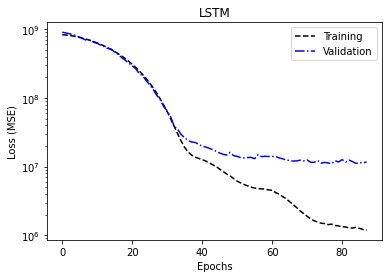

In [ ]:
%%skip $SKIP_RETRAIN_LSTM

fig = plot_learning_curves(histMSLSTM,model_type,f'./{model_type}/learningcurve_{namespace}.png')
fig.show()

Load best model

In [ ]:
model_best_MS_LSTM = keras.models.load_model(f"./{model_type}/my_best_model_{namespace}.h5")
model_best_MS_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          23296     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64)          256       
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          3

In [ ]:
i=1
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))

Y_test_predictions = pd.Series(model_best_MS_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered = data_y_test0.loc[Y_test_predictions.index]


In [ ]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

<ipython-input-158-f128fcf0dccf>:2: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



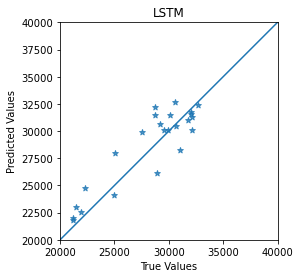

In [ ]:
fig = plot_accuracy(eval_df,model_type,f"./{model_type}/accuracy_{namespace}.png")
fig.show()

<ipython-input-159-05c98d64636b>:2: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



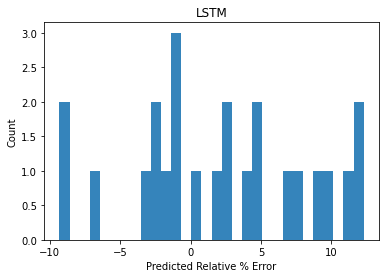

In [ ]:
fig = plot_error_variations(eval_df,model_type,f"./{model_type}/error_variations_{namespace}.png")
fig.show()

In [ ]:
abs_error_MSLSTM = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_MSLSTM)

nan

In [ ]:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.79


<ipython-input-162-c54bd844a7ce>:2: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



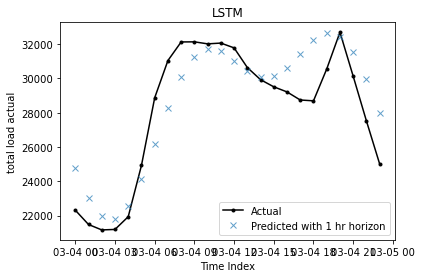

In [ ]:
fig = plot_predictions(eval_df,1,model_type,feature,f"./{model_type}/predictions_{namespace}")
fig.show()

In [ ]:
idx_prediction = pd.date_range(start=idx_test[0],freq='h',periods=len(idx_test)+24)
y_test_filtered2 = data_y_test0.loc[idx_prediction]

In [ ]:
fig = go.Figure()
df_pred =pd.DataFrame(index=y_test_filtered2.index)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=y_test_filtered2[feature]))
for i in range(len(data_x_test)):
    case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
    Y_test_predictions = pd.Series(model_best_MS_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
    df_pred[f'pred_{i}'] = Y_test_predictions
    fig.add_trace(go.Scatter(x = Y_test_predictions.index,y=Y_test_predictions,mode='markers'))

df_pred['mean'] = df_pred.mean(axis=1)
df_pred['median'] = df_pred.median(axis=1)
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['mean']))
fig.add_trace(go.Scatter(x = y_test_filtered2.index,y=df_pred['median']))
fig.show()
eval_df2  =create_eval_df(df_pred['mean'],y_test_filtered2)

In [ ]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered2[:-1],df_pred['mean'][:-1])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.77
